<a href="https://colab.research.google.com/github/gkiflex/MSAI-630-A01/blob/master/conditional_gan_blonde_hair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup environment and import libraries
!pip install tensorflow>=2.8.0 matplotlib pandas numpy Pillow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers

# Parameters
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 10
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LABEL = "Blond_Hair"

# Create directories
os.makedirs('/content/data/celeba-dataset/img_align_celeba', exist_ok=True)
os.makedirs('/content/checkpoint', exist_ok=True)

print("✅ Setup complete!")

✅ Setup complete!


In [2]:
# Create synthetic dataset for demonstration
def create_synthetic_dataset(num_samples=1000):
    # Create attributes file
    image_ids = [f"{i:06d}.jpg" for i in range(1, num_samples + 1)]
    blond_hair = np.random.choice([-1, 1], num_samples)
    attributes = pd.DataFrame({'image_id': image_ids, 'Blond_Hair': blond_hair})
    attributes.to_csv('/content/data/celeba-dataset/list_attr_celeba.csv', index=False)

    # Create synthetic images
    for i in range(num_samples):
        img = np.random.randint(0, 256, (IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.uint8)
        center_x, center_y = IMAGE_SIZE // 2, IMAGE_SIZE // 2

        # Add face-like structure
        for y in range(IMAGE_SIZE):
            for x in range(IMAGE_SIZE):
                dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                if dist < IMAGE_SIZE // 3:
                    img[y, x] = img[y, x] * 0.7 + np.array([200, 180, 160]) * 0.3

        Image.fromarray(img).save(f'/content/data/celeba-dataset/img_align_celeba/{i+1:06d}.jpg')

        if (i + 1) % 200 == 0:
            print(f"Created {i + 1}/{num_samples} images")

    return attributes

attributes = create_synthetic_dataset(1000)
print("✅ Demo dataset created!")

Created 200/1000 images
Created 400/1000 images
Created 600/1000 images
Created 800/1000 images
Created 1000/1000 images
✅ Demo dataset created!


In [3]:
# Load data and preprocess
attributes = pd.read_csv("/content/data/celeba-dataset/list_attr_celeba.csv")
labels = attributes[LABEL].tolist()
int_labels = [1 if x == 1 else 0 for x in labels]

# Create dataset
train_data = utils.image_dataset_from_directory(
    "/content/data/celeba-dataset/img_align_celeba",
    labels=int_labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

# Preprocessing
def preprocess(img):
    return (tf.cast(img, "float32") - 127.5) / 127.5

train = train_data.map(lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES)))

print("✅ Data loaded and preprocessed!")

Found 1000 files belonging to 2 classes.
✅ Data loaded and preprocessed!


In [4]:
# Build Critic
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, 4, 2, "same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, 4, 2, "same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 4, 2, "same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 4, 2, "same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, 4, 1, "valid")(x)
critic_output = layers.Flatten()(x)
critic = models.Model([critic_input, label_input], critic_output)

# Build Generator
generator_input = layers.Input(shape=(Z_DIM,))
gen_label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input, gen_label_input])
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x)
x = layers.Conv2DTranspose(128, 4, 1, "valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, 4, 2, "same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, 4, 2, "same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, 4, 2, "same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, 4, 2, "same", activation="tanh")(x)
generator = models.Model([generator_input, gen_label_input], generator_output)

print("✅ Networks built!")

✅ Networks built!


In [5]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super().compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images, image_one_hot_labels):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic([interpolated, image_one_hot_labels], training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train_step(self, data):
        real_images, one_hot_labels = data

        # Convert labels to spatial format for critic
        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=IMAGE_SIZE, axis=1)
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=IMAGE_SIZE, axis=2)

        batch_size = tf.shape(real_images)[0]

        # Train critic
        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator([random_latent_vectors, one_hot_labels], training=True)
                fake_predictions = self.critic([fake_images, image_one_hot_labels], training=True)
                real_predictions = self.critic([real_images, image_one_hot_labels], training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images, image_one_hot_labels)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors, one_hot_labels], training=True)
            fake_predictions = self.critic([fake_images, image_one_hot_labels], training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        self.c_loss_metric.update_state(c_loss)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

print("✅ ConditionalWGAN implemented!")

✅ ConditionalWGAN implemented!


🚀 Starting training...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - c_loss: -3.4203 - g_loss: 8.1321

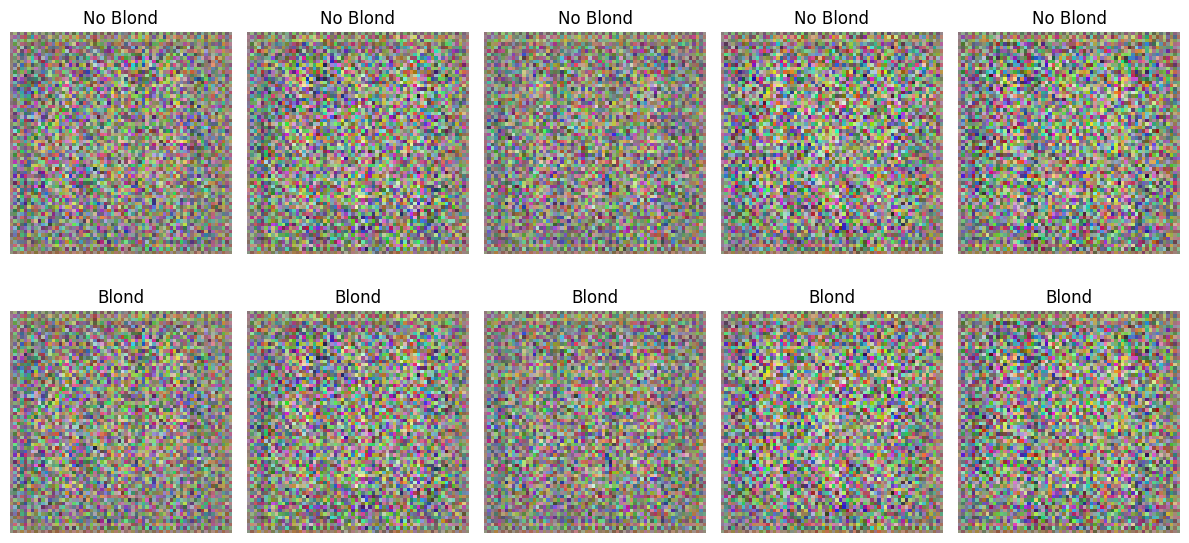

50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 935ms/step - c_loss: -3.5354 - g_loss: 8.2742
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 907ms/step - c_loss: -6.2375 - g_loss: 17.4352
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 923ms/step - c_loss: -12.6021 - g_loss: 15.5246
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 917ms/step - c_loss: -19.1592 - g_loss: 41.0574
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 910ms/step - c_loss: -22.3665 - g_loss: 51.2197
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - c_loss: -22.0857 - g_loss: 55.2356

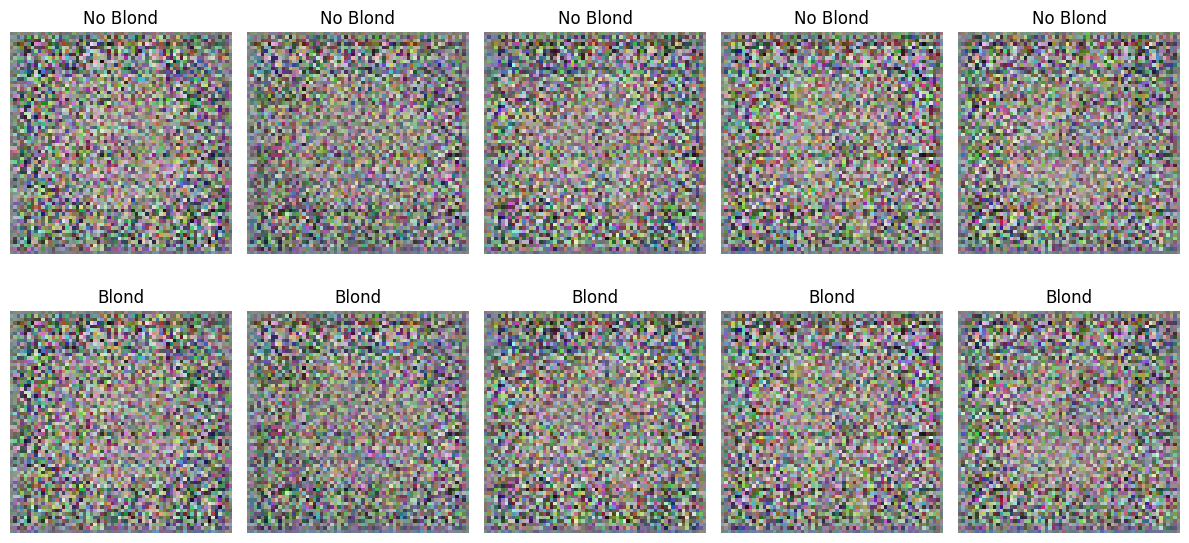

50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 927ms/step - c_loss: -22.0831 - g_loss: 55.2625
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 926ms/step - c_loss: -21.7127 - g_loss: 61.1725
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 929ms/step - c_loss: -20.6488 - g_loss: 67.7966
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 937ms/step - c_loss: -19.5018 - g_loss: 76.9675
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 927ms/step - c_loss: -18.5189 - g_loss: 83.2909
✅ Training complete!


In [6]:
# Create and compile model
cgan = ConditionalWGAN(critic, generator, Z_DIM, CRITIC_STEPS, GP_WEIGHT)
cgan.compile(
    c_optimizer=optimizers.Adam(LEARNING_RATE, ADAM_BETA_1, ADAM_BETA_2),
    g_optimizer=optimizers.Adam(LEARNING_RATE, ADAM_BETA_1, ADAM_BETA_2)
)

# Training callback for visualization
class ImageCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            z = np.random.normal(size=(5, Z_DIM))

            # Generate without blond hair
            no_blond = np.tile([[1, 0]], (5, 1))
            imgs_no_blond = self.model.generator.predict([z, no_blond], verbose=0)
            imgs_no_blond = (imgs_no_blond + 1) * 127.5

            # Generate with blond hair
            blond = np.tile([[0, 1]], (5, 1))
            imgs_blond = self.model.generator.predict([z, blond], verbose=0)
            imgs_blond = (imgs_blond + 1) * 127.5

            fig, axes = plt.subplots(2, 5, figsize=(12, 6))
            for i in range(5):
                axes[0, i].imshow(imgs_no_blond[i].astype(np.uint8))
                axes[0, i].set_title("No Blond")
                axes[0, i].axis('off')
                axes[1, i].imshow(imgs_blond[i].astype(np.uint8))
                axes[1, i].set_title("Blond")
                axes[1, i].axis('off')
            plt.tight_layout()
            plt.show()

# Add repeat to dataset to avoid running out of data
train_repeated = train.repeat()

# Train the model
print("🚀 Starting training...")
history = cgan.fit(
    train_repeated,
    epochs=EPOCHS,
    steps_per_epoch=50,
    callbacks=[ImageCallback()],
    verbose=1
)
print("✅ Training complete!")